In [1]:
import networkx as nx
import numpy as np
import random
from random import randint

In [2]:
def rand_ints(mean, std, size):
    randomNums = np.random.normal(loc=mean, scale=std, size=size)
    randomInts = np.round(randomNums)
    randomInts = list(randomInts)
    f_randomInts = [int(x) if x>=2 else 1 for x in randomInts]
    return f_randomInts

def rand_data (mean, std, size):
    randomNums = np.random.normal(loc=mean, scale=std, size=size)
    randomInts = np.round(randomNums)
    randomInts = list(randomInts)
    lower = int(mean-(std*2))
    d_randomInts = [int(x) if x>=lower else lower for x in randomInts]
    return d_randomInts

def rand_trust(mean, std, size):
    randomNums = np.random.normal(loc=mean, scale=std, size=size)
    randomNums = list(randomNums)
    t_random = []
    for x in randomNums:
        
        if x >=0.99:
            t_random.append(0.97)
        elif x < (mean-std):
            t_random.append(mean-std)
        else:
            t_random.append(x)
    
    return t_random



#-----------generate SIoT node and communication topology----------------
def generated_node(size, degree, cmp_mean, cmp_std, 
                   cmu_mean, cmu_std, 
                   lab, iid, primary, num_data, d_std_ratio, l_std_ratio):
    
#-----------generate SIoT node with computation cost and data -------------
    SIoT_nodes = []
    # generate the computation cost
    computation_costs = rand_ints(cmp_mean, cmp_std, size)
    data_distribution = rand_data(num_data, num_data*d_std_ratio, size)
    print("total data:",sum(data_distribution))
#     print(data_distribution)
    # generate the node with the computation cost and the data distribution
    #iid setting
    if iid:
        print ("Data distribution is IID.")
        for x, y in enumerate(computation_costs):
        
            n_data = data_distribution[x]
            l_std = l_std_ratio*n_data/lab
        
            # generate the label distribution
            label_num = rand_ints(n_data/lab, l_std, lab)
            
            #combine the computation cost and data distribution
            node_info = (x, {"cmp":y,
                            "total_data": sum(label_num),
                            "d_data": label_num,
                            "p_level": 0,      # the privacy requirment 
                            "pri_n": -1})    # the node that let it has this p_level 
            SIoT_nodes.append(node_info)
    
    else:
        print ("Data distribution is non-IID.")
        for x, y in enumerate(computation_costs):
            
            n_data = data_distribution[x]
    
            i = randint(0, lab-1)
            label_num = rand_ints(3, 1, lab)
            label_num[i] = int (n_data*primary)
            node_info = (x, {"cmp":y,
                            "total_data": sum(label_num),
                            "d_data": label_num,
                            "p_level": 0,      # the privacy requirment 
                            "pri_n": -1})    # the node that let it has this p_level 
            SIoT_nodes.append(node_info)

#-----------generate SIoT edge with communication cost -------------    
    
    edges = []
    # generate edges
    for x in range(num_node):
        e = []
        x_degree = randint(1, node_degree)    # for construst example
        while(len(e)< node_degree):
            i = randint(0, num_node-1)
            if (i not in e and i!= x):
                e.append(i)
        for j in e:
            edges.append((x,j))

    # remove duplicate edges  EX. (a,b), (b,a)  
    for e in edges:
        if ((e[1], e[0]) in edges):
            edges.remove((e[1], e[0]))

    #generate the communication cost
    communication_costs = rand_ints(cmu_mean, cmu_std, len(edges))

    #combine the edges and the communication cost
    edges_cmu = [(edges[x][0], edges[x][1], {"cmu":y}) for x, y in enumerate(communication_costs)]
    
    return SIoT_nodes, edges_cmu



def assign_SIoT_to_user(node, user, ratio):   
    avg_node = int((1-ratio)*node/user)
    nodes = list(range(node))
    node_distribution = {}
    user_distribution = {}
    SIoT_num=[3,2,1,2,1,3]
    # assign SIoT to user
    for x in range(user):
        assign_nodes = sorted(random.sample(nodes, SIoT_num[x]))
        node_distribution[x] = assign_nodes

        # remove the assigned nodes
        for i in assign_nodes:
            nodes.remove(i)

    # assign the remaining nodes
    node_distribution["public"] = nodes
    
    
    #construct the SIoT-to-user dict.
    for u, SIoTs in node_distribution.items():
        for s in SIoTs:
            user_distribution[s] = u
            
    return node_distribution, user_distribution


#-----------generate the trust table of the users -------------
def con_trust_table(n_user):
    trust_table = [[0]*n_user for i in range(n_user)]
    num_trust = int(n_user*(n_user-1)/2)
    trusts = rand_trust(trust_mean, trust_std, num_trust)
    for i in range(0, n_user):
        trust_table[i][i] = 1.0
    k=0
    for i in range(0, n_user):
        for j in range(i+1, n_user):
            trust_table[i][j] = float(format(trusts[k], '.2f'))
            trust_table[j][i] = float(format(trusts[k], '.2f'))
            k+=1
    return trust_table

In [3]:
# ---------Step1. SIoT Selection and Clustering ~~~ Function ------------ 


# ---------compute the vaild number of labels ------------
def cmp_vaild_data(data):
    v_n_data = 0    # vaild the number of data 
    for i in range(0, label):
        if ((l_num_data[i] - data[i])>=0):
            v_n_data += data[i]
        else:
            v_n_data += l_num_data[i]

    return v_n_data


# ---------updata the lacking number of labels ------------
def update_l_data(data):
    print("Current the lacking number of labels  :",l_num_data)
    print("Current the removing number of labels :",data)
    for i in range(0, label):
        total_num_data[i] += data[i]
        if ((l_num_data[i] - data[i])>=0):
            l_num_data[i] -= data[i]
        else:
            l_num_data[i] =0

    print("The lacking number of labels after update:",l_num_data)
    print("----------------total data---------------:",total_num_data)
    

# --------- compute trust-to-privacy, privacy-to-cost------------
def trust_to_privacy(t):
    return float(format(epsilon*t/(t+sigma), '.2f'))

def trust_to_cost(t):
    return float(format((1-trust_to_privacy(t)/epsilon)*p_cost, '.2f'))

def privacy_to_cost(p):
    return float(format((1-p/epsilon)*p_cost, '.2f'))



# --------- get the user who own this SIoT ------------
def get_user(i):
    return s_u_table[i]


# --------- get the trust betweent two SIoT ------------
def get_2SIoT_trust(i,j):
    
    u1 = s_u_table[i]
    u2 = s_u_table[j]
    
    if (u1=='public') or (u2=='public'):
        return 1.0
    else: 
        return users_trust[u1][u2]
    
    
    
# --------- create new cluster info. ------------    
def create_cluster(p):
    
    G = nx.Graph()
    n = [(p[0], G_s.nodes[p[0]]),(p[1], G_s.nodes[p[1]])]
    e = [(p[0], p[1], G_s[p[0]][p[1]])]
    G.add_nodes_from(n)
    G.add_edges_from(e)
    cluster_info={
        'id': len(clusters),
        'graph': G,
        'node': [p[0], p[1]],
        'p_level': get_2SIoT_trust(p[0], p[1]),
        'CH': None,
        'total_cmp':0,
        'total_cmu':0,
        'total_hir':0,
        'total_pri':0,
        'total_cst':0
        
    }
    clusters.append(cluster_info)    
    
# --------- find the candidate pair ------------    
def find_cnd_c(ps):
    cnd_c = None
    CP_c = 0
    for p in ps :
        cmp_cost = G_s.nodes[p[0]]['cmp']+G_s.nodes[p[1]]['cmp']
        cmu_cost = G_s[p[0]][p[1]]['cmu']
        
        if (get_user(p[0])=='public'):
            hir_cost_p_0 = 0
        else: 
            hir_cost_p_0 = G_s.nodes[p[0]]['total_data']*u_data
            
        if (get_user(p[1])=='public'):
            hir_cost_p_1 = 0
        else :
            hir_cost_p_1 = G_s.nodes[p[1]]['total_data']*u_data    
        
        hir_cost = hir_cost_p_0+hir_cost_p_1

        t = get_2SIoT_trust(p[0],p[1])
        pri_cost = 2*trust_to_cost(t)
        t_cost = cmp_cost + cmu_cost + hir_cost + pri_cost + cc_cost
#          print ("cmp_cost:{}, cmu_cost: {}, hir_cost:{}, pri_cost:{} and t_cost:{}"
#                .format(cmp_cost, cmu_cost, hir_cost, pri_cost, t_cost))


        t_dataset = [G_s.nodes[p[0]]['d_data'][i]+G_s.nodes[p[1]]['d_data'][i] for i in range(0, label)]
        v_data = cmp_vaild_data(t_dataset)
#         print("t_dataset:{}, v_data:{}".format(t_dataset, v_data))

        CP = v_data/t_cost
#         print ("CP is ", CP )
        
        if (CP >= CP_c):
            cnd_c = p
            CP_c = CP
    return cnd_c, CP_c



# --------- find the min cmu edge of SIoT i in cluster c------------ 
def get_min_cmu_edge(i,c):
    i_nbr = set(G_s.neighbors(i))
    i_nbr = i_nbr & set(c)
    cmu = 10000
    n = None
    for j in i_nbr:
        if (cmu>G_s[i][j]['cmu']):
            cmu = G_s[i][j]['cmu']
            n = j
    return n



# --------- find the min trust of SIoT i and cluster c------------
def get_min_trust(i,c, min_trust):
    min_t = min_trust
    for j in c:
        if (min_t > get_2SIoT_trust(i, j)):
            min_t = get_2SIoT_trust(i, j)
    return min_t



#---------- find the candidate SIoT of each cluster --------------
def find_c_SIoTs(cs):
    cnd_SIoTs = []
    for c in cs:
        adj_c =set()
        for n in c['node']:
            adj_c = adj_c|set(G_s.neighbors(n))
        adj_c = adj_c - hired_SIoTs
    #     print(adj_c)

        cnd_s = None
        CP_s = 0
        nbr_min_c = None
        min_trust = 0
        for nbr in adj_c:       
            cmp_cost = G_s.nodes[nbr]['cmp']

            # find the SIoT that has min cmu edge connected the SIoT nbr in cluster c 
            nbr_min = get_min_cmu_edge(nbr,c['node'])
            cmu_cost = G_s[nbr][nbr_min]['cmu']
            
            if (get_user(nbr)=="public"):
                hir_cost = 0 
            else:
                hir_cost = G_s.nodes[nbr]['total_data']*u_data

            # find the min trust if the SIoT nbr joins the cluster c 
            nbr_min_t = get_min_trust(nbr, c['node'], c['p_level'])
            pri_cost = trust_to_cost(nbr_min_t)

            t_cost = cmp_cost + cmu_cost + hir_cost + pri_cost

            v_data = cmp_vaild_data(G_s.nodes[nbr]['d_data'])
            CP = v_data/t_cost
            if (CP >= CP_s):
                cnd_s = nbr
                CP_s = CP
                nbr_min_c = nbr_min
                min_trust = nbr_min_t

        cnd_SIoT = {'cluster_id': c['id'], 'node_id':cnd_s, 'CP_s': CP_s, "nbr_min_c":nbr_min_c,'min_trust': min_trust }
        cnd_SIoTs.append(cnd_SIoT)
    return cnd_SIoTs



#---------- find the highest CP SIoT from all condidate SIoTs --------------
def get_c_SIoT(SIoTs):
    SIoT = None
    CP = 0
    for s in SIoTs:
        if (s['CP_s'] > CP):
            SIoT = s
            CP = s['CP_s']
    return SIoT



#---------- check the data coverage constraint whether has satisfied  --------------
def check_data_coverage():
    for l in l_num_data:
        if(l!=0):
            return False
    return True

In [37]:
# --------- Step2. Data balancing for each cluster ~~~ Function ------------


#--------- find the cluster with max and min data size ------------
def find_max_min_c():
    max_c = 0
    max_d = sum([G_s.nodes[x]['total_data'] for x in clusters[0]['node']])
    min_c = 0
    min_d = sum([G_s.nodes[x]['total_data'] for x in clusters[0]['node']])
    
    for c in clusters:
        c_d = sum([G_s.nodes[x]['total_data'] for x in c['node']])
        
        if (c_d > max_d):
            max_d = c_d
            max_c = c['id']
            continue
        if (c_d < min_d):
            min_d = c_d
            min_c = c['id']
    
    return max_c, min_c, (max_d-min_d) < D 



#--------- find the leaf of the cluster ------------
def find_leaf_node(c):
    leaf = []
    for n in c['node']:
        if (c['graph'].degree(n) == 1):
            leaf.append(n)
    return leaf


#--------- check remove the node that has still satisfied data coverage constraint  ------------
def check_remove_node(l):
    lc = [total_num_data[i]-G_s.nodes[l]['d_data'][i] for i in range(0, label)]
#     print(l, lc)
    for i in range(0, label):
        if (total_num_data[i]-G_s.nodes[l]['d_data'][i] < B):
            return False
    return True
            


#--------- find the leaf node that satisfies data coverage constraint ------------
def find_cd_leaf_node(c):
    leaf = find_leaf_node(c)
    cd_leaf = []
    
    for l in leaf:
        if (check_remove_node(l)):
            cd_leaf.append(l)
            
    return cd_leaf



#--------- find the highest cost node in leaf ------------
def find_max_cost_leaf(leaf, c_id):
    cost = 0
    s_id = None
    for l in leaf:
        cmp = cmp_cost = G_s.nodes[l]['cmp']
        
        nbr = list(clusters[c_id]['graph'].neighbors(l))[0]
        cmu_cost = G_s[l][nbr]['cmu']
        if (get_user(l)=="public"):
            hir_cost = 0 
        else:
            hir_cost = G_s.nodes[l]['total_data']*u_data
        t_cost = cmp_cost + cmu_cost + hir_cost
#         print (l , t_cost)
        if (t_cost > cost):
            cost = t_cost
            s_id = l
    return s_id, 



#--------- find the leaf node that satisfies data coverage constraint ------------
def find_highCP_s(c):
    adj_c =set()
    for n in c['node']:
        adj_c = adj_c|set(G_s.neighbors(n))
    adj_c = adj_c - hired_SIoTs
    #     print(adj_c)
    cnd_s = None
    CP_s = 0
    nbr_min_c = None
    min_trust = 0
    for nbr in adj_c:       
        cmp_cost = G_s.nodes[nbr]['cmp']

        # find the SIoT that has min cmu edge connected the SIoT nbr in cluster c 
        nbr_min = get_min_cmu_edge(nbr,c['node'])
        cmu_cost = G_s[nbr][nbr_min]['cmu']
        if (get_user(nbr)=="public"):
            hir_cost = 0 
        else:
            hir_cost = G_s.nodes[nbr]['total_data']*u_data

        # find the min trust if the SIoT nbr joins the cluster c 
        nbr_min_t = get_min_trust(nbr, c['node'], c['p_level'])
        pri_cost = trust_to_cost(nbr_min_t)

        t_cost = cmp_cost + cmu_cost + hir_cost + pri_cost

        CP = G_s.nodes[nbr]['total_data']/t_cost
        if (CP >= CP_s):
            cnd_s = nbr
            CP_s = CP
            nbr_min_c = nbr_min
            min_trust = nbr_min_t

    cnd_SIoT = {'cluster_id': c['id'], 'node_id':cnd_s, 'CP_s': CP_s, "nbr_min_c":nbr_min_c,'min_trust': min_trust }
    
    
    return cnd_SIoT, CP_s

In [5]:
# --------- Step 3. Cluster head(CH) decision and Rerouting ~~~functoin ------------

# --------- get the minimum privacy level of node n on path p and the node that let n has this privacy requirment ------------
def get_min_plevel(n, p):
    min_p = 1
    pri_n = None
    for i in p:
        if (get_2SIoT_trust(n, i) < min_p):
            min_p = get_2SIoT_trust(n, i)
            pri_n = i
    return min_p, pri_n


# --------- get the total cost if node n is cluster head ------------
def get_total_cost(n, c):
    nodes = c['node']
    s_ps = []    # record shortest paths of all node to node n
    total_cmu = 0
    total_pri = 0
    min_p_level = 1
    # get all shortest paths
    for i in nodes:
        if (i == n):
            continue
        s_ps.append(nx.shortest_path(c['graph'],source=i,target=n, weight='cmu'))
        
    # compute total communication cost
    for sp in s_ps:
        for i in range(1, len(sp)):
            total_cmu += G_s[sp[i-1]][sp[i]]['cmu']
    
    #find the min p level
    for sp in s_ps:
        min_p, _ = get_min_plevel(sp[0], sp)
        if (min_p < min_p_level):
            min_p_level = min_p
    
    #compute the total privacy cost
    total_pri = len(nodes)*trust_to_cost(min_p_level) 
#     print(min_p_level)

    return total_cmu + total_pri



# --------- get the node with minimum total cost in the cluster c ------------
def get_ch(c_ch, c):
    ch = None
    cost = 9999999
    for n in c_ch:
        n_cost = get_total_cost(n, c)
#         print (n_cost , n)
        if (n_cost<cost):
            cost = n_cost
            ch = n
    return ch



# --------- set node ch as the cluster head of the cluster c ------------
def set_ch(ch, c):
    c_id = c['id']
    nodes = c['node']
    s_ps = []    # record shortest paths of all node to node n
    total_cmp = sum([G_s.nodes[i]['cmp'] for i in nodes])
    total_cmu = 0
    total_hir = 0
    for i in nodes:
        if (get_user(i)=="public"):
            continue 
        total_hir +=  G_s.nodes[i]['total_data']*u_data
    total_pri = 0
    min_p_level = 1
    # get all shortest paths
    for i in nodes:
        if (i == ch):
            continue
        s_ps.append(nx.shortest_path(c['graph'],source=i,target=ch, weight='cmu'))
        
    # compute total communication cost
    for sp in s_ps:
        for i in range(1, len(sp)):
            total_cmu += G_s[sp[i-1]][sp[i]]['cmu']
    
    #find the min p level
    for sp in s_ps:
        min_p, pri_n = get_min_plevel(sp[0], sp)
        
        #set node info
        c['graph'].nodes[sp[0]]['p_level'] = min_p
        c['graph'].nodes[sp[0]]['pri_n'] = pri_n
        
        if (min_p < min_p_level):
            min_p_level = min_p
    c['graph'].nodes[ch]['p_level'] = 1
    c['graph'].nodes[ch]['pri_n'] = ch
    
    
    #compute the total privacy cost
    total_pri = len(nodes)*trust_to_cost(min_p_level) 
    
    # set cluster info 
    clusters[c_id]['p_level'] = min_p_level
    clusters[c_id]['CH'] = ch
    clusters[c_id]['total_cmp'] = total_cmp
    clusters[c_id]['total_cmu'] = total_cmu
    clusters[c_id]['total_hir'] = float(format(total_hir, '.2f'))
    clusters[c_id]['total_pri'] = float(format(total_pri, '.2f'))
    clusters[c_id]['total_cst'] = total_cmp + total_cmu + float(format(total_hir, '.2f')) + float(format(total_pri, '.2f'))
    
    

# get the minimum privacy level node in the cluster c
def get_min_pl_n(c):
    
    min_n = None
    min_l = 1
    for i in list(c['node']):
#         print (i , c['graph'].nodes[i]['p_level'])
        if (c['graph'].nodes[i]['p_level'] < min_l):
            min_n = i
            min_l = c['graph'].nodes[i]['p_level']
    
    return min_n
    
# compute the total cost
def cmp_t_cost(G, ch):
    
    nodes = G.nodes()
    s_ps = []    # record shortest paths of all node to node n
    total_cmp = sum([G_s.nodes[i]['cmp'] for i in nodes])
    total_cmu = 0
    total_hir = 0
    for i in nodes:
        if (get_user(i)=="public"):
            continue 
        total_hir +=  G_s.nodes[i]['total_data']*u_data
    total_pri = 0
    min_p_level = 1
    # get all shortest paths
    for i in nodes:
        if (i == ch):
            continue
        try:
            s_ps.append(nx.shortest_path(G,source=i,target=ch, weight='cmu'))
        except:
            return 100000
    # compute total communication cost
    for sp in s_ps:
        for i in range(1, len(sp)):
            total_cmu += G_s[sp[i-1]][sp[i]]['cmu']
    
    #find the min p level
    for sp in s_ps:
        min_p, pri_n = get_min_plevel(sp[0], sp)
        
        if (min_p < min_p_level):
            min_p_level = min_p
    
    
    #compute the total privacy cost
    total_pri = len(nodes)*trust_to_cost(min_p_level) 
    
    return total_cmp + total_cmu + total_pri + total_hir



#  rerouting
def rerouting(c):
    min_n = get_min_pl_n(c)
    pri_n = c['graph'].nodes[min_n]['pri_n']
    path = nx.shortest_path(c['graph'],source=min_n,target=pri_n, weight='cmu')
    
    G_c = nx.Graph(G_s)
    nodes = set(G_c.nodes) - set(c['node'])
    G_c.remove_nodes_from(list(nodes))
#     nx.draw(G_c)
    ori = None
    cnd = None
    t_cost = c['total_cst']
    
    for n in list(path)[:-1]:
        cnd_e = G_c.edges([n])
        ori_e = None
#         print(G_c.edges([n]))
        # find original edge of the node n 
        for e in cnd_e:
            if e in list(c['graph'].edges) or (e[1],e[0]) in list(c['graph'].edges):
                ori_e = e
        
        for e in cnd_e:
            # skip the original path 
            if e in list(c['graph'].edges) or (e[1],e[0]) in list(c['graph'].edges):
                continue
                
            G_d = nx.Graph(c['graph'])
#             print(e, ori_e)
            
            G_d.remove_edges_from([ori_e])
            
            G_d.add_edges_from([(e[0], e[1], G_s[e[0]][e[1]])])
            
            cost = cmp_t_cost(G_d, c['CH'])
            
            if (t_cost > cost):
                t_cost = cost
                ori = ori_e
                cnd = e
#             print(t_cost, c['total_cst'])
#     print(ori, cnd)
    return ori, cnd, ori != None




#  exchange the two edge 
def change_route(ori_e, rerout_e, c_id):
    clusters[c_id]['graph'].remove_edges_from([ori_e])        
    clusters[c_id]['graph'].add_edges_from([(rerout_e[0], rerout_e[1], G_s[rerout_e[0]][rerout_e[1]])])
    print ("change {} to {}".format(ori_e, rerout_e))
    
    
    
def update_c_info (c_id): 
    nodes = clusters[c_id]['node']
    ch = clusters[c_id]['CH']
    ori_cost = clusters[c_id]['total_cst']
    s_ps = []    # record shortest paths of all node to node n
    total_cmp = sum([G_s.nodes[i]['cmp'] for i in nodes])
    total_cmu = 0
    total_hir = 0
    for i in nodes:
        if (get_user(i)=="public"):
            continue 
        total_hir +=  G_s.nodes[i]['total_data']*u_data
    total_pri = 0
    min_p_level = 1
    # get all shortest paths
    for i in nodes:
        if (i == ch):
            continue
        s_ps.append(nx.shortest_path(clusters[c_id]['graph'],source=i,target=ch, weight='cmu'))
        
    # compute total communication cost
    for sp in s_ps:
        for i in range(1, len(sp)):
            total_cmu += G_s[sp[i-1]][sp[i]]['cmu']
    
    #find the min p level
    for sp in s_ps:
        min_p, pri_n = get_min_plevel(sp[0], sp)
        
        #set node info
        clusters[c_id]['graph'].nodes[sp[0]]['p_level'] = min_p
        clusters[c_id]['graph'].nodes[sp[0]]['pri_n'] = pri_n
        
        if (min_p < min_p_level):
            min_p_level = min_p
    
    #compute the total privacy cost
    total_pri = len(nodes)*trust_to_cost(min_p_level) 
    
    # set cluster info 
    clusters[c_id]['p_level'] = min_p_level
    clusters[c_id]['total_cmp'] = total_cmp
    clusters[c_id]['total_cmu'] = total_cmu
    clusters[c_id]['total_hir'] = float(format(total_hir, '.2f'))
    clusters[c_id]['total_pri'] = float(format(total_pri, '.2f'))
    clusters[c_id]['total_cst'] = total_cmp + total_cmu + float(format(total_hir, '.2f')) + float(format(total_pri, '.2f'))
    
    return ori_cost - clusters[c_id]['total_cst']



def get_overall_cost():
    overall_cmp = sum([c['total_cmp'] for c in clusters])
    overall_cmu = sum([c['total_cmu'] for c in clusters])
    overall_hir = sum([c['total_hir'] for c in clusters])
    overall_pri = sum([c['total_pri'] for c in clusters])
    
    overall_cst = overall_cmp + overall_cmu + overall_hir + overall_pri
    
    return [overall_cmp, overall_cmu, overall_hir, overall_pri, overall_cst]

In [19]:
# for example 

# node info
num_node = 14
node_degree = 2
computation_mean = 5
computation_std = 2
communication_mean = 5
communication_std = 2
public_ratio = 0.15
cc_cost = 8      #communication cost of connected cloud

# user info
num_user = 6
trust_mean = 0.75
trust_std = 0.3
u_s_table = {}   # user-to-SIoT table
s_u_table = {}   # SIoT-to-user table
users_trust=[]   # trust table

# data distribution
label = 5
IID = True
primary = 0.5
data_mean = 20
data_std_ratio = 0.2    #need to less than 0.45
label_std_ratio = 0.1   #need to less than 0.45

# hiring cost
u_data = 0.2   # unit data cost
hired_SIoTs =set()

# privacy setting
sigma = 0.3      # adjustable parameter ~[0,1]
epsilon = 15      # privacy intensity parameter
p_cost = 30     # privacy cost

# data coverage threshold
B = 40
l_num_data = [B]*label
total_num_data = [0]*label

# data balancing threshold
D = 20

#cluster info 
clusters=[]

#---------------create SIoT topology and user trust------------------
print ("The system has {} SIoTs and {} users".format(num_node, num_user))
G_s = nx.Graph()
V_s, E_s = generated_node(num_node, node_degree, 
                            computation_mean, computation_std, 
                            communication_mean, communication_std,
                            label, IID, primary, data_mean, data_std_ratio, label_std_ratio)
G_s.add_nodes_from(V_s)
G_s.add_edges_from(E_s)


# assign the SIoTs to the users
u_s_table, s_u_table = assign_SIoT_to_user(num_node, num_user, public_ratio)

# compute trust between each user(i.e., construct the trust table)
users_trust = con_trust_table(num_user)
# ---------Step1. SIoT Selection and Clustering ------------ 

G_r = nx.Graph(G_s)
pairs = list(G_r.edges())

# construct the initial cluster
init_pair, _ = find_cnd_c(pairs)
# print ("The initial Cluster is {}".format(init_pair))
init_dataset = [G_s.nodes[init_pair[0]]['d_data'][i]+G_s.nodes[init_pair[1]]['d_data'][i] for i in range(0, label)]
update_l_data(init_dataset)

#  record the cluster info.
create_cluster(init_pair)

# record the hired SIoTs
hired_SIoTs.update([init_pair[0], init_pair[1]])      

# remove initial cluster 
G_r.remove_nodes_from([init_pair[0] ,init_pair[1] ])
# print ("Remove the node {} and {} from G_r".format(init_pair[0] ,init_pair[1]))
round = 0
while (not(check_data_coverage())):
    
#     print('\n')
    print('---------------- Round {} ---------------'.format(round))
    round+=1
    
    c_SIoT = None
    
    #  find the candidate SIoT of each cluster
    c_SIoTs = find_c_SIoTs(clusters)
    
    # get the highest CP SIoT from all condidate SIoTs
    c_SIoT = get_c_SIoT(c_SIoTs)
    
    # find the candidate cluster
    pairs = list(G_r.edges())
    c_pair, c_CP = find_cnd_c(pairs) 
    
#     print (c_SIoTs)
#     print(c_SIoT)
#     print("The c_pair:{}, CP:{} ".format(c_pair, c_CP))
    
    # compare the CP between the c_SIoT and c_pair 
    if (c_SIoT['CP_s'] >= c_CP and (c_SIoT['CP_s'] != None)):
        # add the c_SIoT to coressponding cluster
        cluster_id = c_SIoT['cluster_id']
        node_id = c_SIoT['node_id']
        print("add the node {} to the cluster {}".format(node_id, cluster_id))
        print("node {} CP is {}".format(node_id, c_SIoT['CP_s']) )
        clusters[cluster_id]['node'].append(node_id)
        clusters[cluster_id]['p_level'] = c_SIoT['min_trust']
        clusters[cluster_id]['graph'].add_nodes_from([(node_id, G_s.nodes[node_id] )])
        clusters[cluster_id]['graph'].add_edges_from([(node_id, c_SIoT['nbr_min_c'], G_s[node_id][c_SIoT['nbr_min_c']])])
        update_l_data(G_s.nodes[node_id]['d_data'])
        hired_SIoTs.add(node_id)
        
#         print ("Remove the node {} from G_r".format(node_id))
        G_r.remove_node(node_id)
    
    else:
#         print("create the new cluster ({},{}) as cluster {}".format(c_pair[0] ,c_pair[1], len(clusters)))
        print(" the new cluster ({},{}) cp is {}".format(c_pair[0] ,c_pair[1], c_CP))
              
        c_dataset = [G_s.nodes[c_pair[0]]['d_data'][i]+G_s.nodes[c_pair[1]]['d_data'][i] for i in range(0, label)]
        update_l_data(c_dataset)

        #  record the cluster info.
        create_cluster(c_pair)

        # record the hired SIoTs
        hired_SIoTs.update([c_pair[0], c_pair[1]])      

        # remove initial cluster 
        G_r.remove_nodes_from([c_pair[0] ,c_pair[1] ])
#         print ("Remove the node {} and {} from G_r".format(c_pair[0] ,c_pair[1]))
print("----------------total data---------------:",total_num_data)

The system has 14 SIoTs and 6 users
total data: 266
Data distribution is IID.
Current the lacking number of labels  : [40, 40, 40, 40, 40]
Current the removing number of labels : [8, 8, 7, 7, 7]
The lacking number of labels after update: [32, 32, 33, 33, 33]
----------------total data---------------: [8, 8, 7, 7, 7]
---------------- Round 0 ---------------
add the node 9 to the cluster 0
node 9 CP is 1.1574074074074074
Current the lacking number of labels  : [32, 32, 33, 33, 33]
Current the removing number of labels : [5, 4, 4, 3, 4]
The lacking number of labels after update: [27, 28, 29, 30, 29]
----------------total data---------------: [13, 12, 11, 10, 11]
---------------- Round 1 ---------------
 the new cluster (2,3) cp is 0.9770114942528735
Current the lacking number of labels  : [27, 28, 29, 30, 29]
Current the removing number of labels : [9, 11, 9, 11, 11]
The lacking number of labels after update: [18, 17, 20, 19, 18]
----------------total data---------------: [22, 23, 20, 21,

In [974]:
clusters

[{'id': 0,
  'graph': <networkx.classes.graph.Graph at 0x7f162bebe8d0>,
  'node': [5, 13, 2],
  'p_level': 0.77,
  'CH': None,
  'total_cmp': 0,
  'total_cmu': 0,
  'total_hir': 0,
  'total_pri': 0,
  'total_cst': 0},
 {'id': 1,
  'graph': <networkx.classes.graph.Graph at 0x7f162bebeed0>,
  'node': [7, 8],
  'p_level': 1.0,
  'CH': None,
  'total_cmp': 0,
  'total_cmu': 0,
  'total_hir': 0,
  'total_pri': 0,
  'total_cst': 0},
 {'id': 2,
  'graph': <networkx.classes.graph.Graph at 0x7f162bebee50>,
  'node': [1, 9, 3],
  'p_level': 0.55,
  'CH': None,
  'total_cmp': 0,
  'total_cmu': 0,
  'total_hir': 0,
  'total_pri': 0,
  'total_cst': 0},
 {'id': 3,
  'graph': <networkx.classes.graph.Graph at 0x7f162bebeb90>,
  'node': [4, 12],
  'p_level': 1.0,
  'CH': None,
  'total_cmp': 0,
  'total_cmu': 0,
  'total_hir': 0,
  'total_pri': 0,
  'total_cst': 0}]

In [41]:
G_r = nx.Graph(G_s)
pairs = list(G_r.edges())

# construct the initial cluster
init_pair, init_CP = find_cnd_c(pairs)
print ("The initial Cluster is {} and CP is {}".format(init_pair, init_CP))
init_dataset = [G_s.nodes[init_pair[0]]['d_data'][i]+G_s.nodes[init_pair[1]]['d_data'][i] for i in range(0, label)]
update_l_data(init_dataset)

#  record the cluster info.
create_cluster(init_pair)

# record the hired SIoTs
hired_SIoTs.update([init_pair[0], init_pair[1]])      

# remove initial cluster 
G_r.remove_nodes_from([init_pair[0] ,init_pair[1] ])
print ("Remove the node {} and {} from G_r".format(init_pair[0] ,init_pair[1]))
round = 0
while (not(check_data_coverage())):
    
#     print('\n')
    print('---------------- Round {} ---------------'.format(round))
    round+=1
    
    c_SIoT = None
    
    #  find the candidate SIoT of each cluster
    c_SIoTs = find_c_SIoTs(clusters)
    
    # get the highest CP SIoT from all condidate SIoTs
    c_SIoT = get_c_SIoT(c_SIoTs)
    
    # find the candidate cluster
    pairs = list(G_r.edges())
    c_pair, c_CP = find_cnd_c(pairs) 
    
#     print (c_SIoTs)
#     print(c_SIoT)
    print("The c_SIoT:{}, CP:{} ".format(c_SIoT['node_id'], c_SIoT['CP_s']))
    print("The c_pair:{}, CP:{} ".format(c_pair, c_CP))
    
    
    # compare the CP between the c_SIoT and c_pair 
    if (c_SIoT['CP_s'] >= c_CP and (c_SIoT['CP_s'] != None)):
        # add the c_SIoT to coressponding cluster
        cluster_id = c_SIoT['cluster_id']
        node_id = c_SIoT['node_id']
        print("add the node {} to the cluster {}".format(node_id, cluster_id))
#         print("node {} CP is {}".format(node_id, c_SIoT['CP_s']) )
        clusters[cluster_id]['node'].append(node_id)
        clusters[cluster_id]['p_level'] = c_SIoT['min_trust']
        clusters[cluster_id]['graph'].add_nodes_from([(node_id, G_s.nodes[node_id] )])
        clusters[cluster_id]['graph'].add_edges_from([(node_id, c_SIoT['nbr_min_c'], G_s[node_id][c_SIoT['nbr_min_c']])])
        update_l_data(G_s.nodes[node_id]['d_data'])
        hired_SIoTs.add(node_id)
        
#         print ("Remove the node {} from G_r".format(node_id))
        G_r.remove_node(node_id)
    
    else:
#         print("create the new cluster ({},{}) as cluster {}".format(c_pair[0] ,c_pair[1], len(clusters)))
        print(" the new cluster ({},{})".format(c_pair[0] ,c_pair[1]))
              
        c_dataset = [G_s.nodes[c_pair[0]]['d_data'][i]+G_s.nodes[c_pair[1]]['d_data'][i] for i in range(0, label)]
        update_l_data(c_dataset)

        #  record the cluster info.
        create_cluster(c_pair)

        # record the hired SIoTs
        hired_SIoTs.update([c_pair[0], c_pair[1]])      

        # remove initial cluster 
        G_r.remove_nodes_from([c_pair[0] ,c_pair[1] ])
#         print ("Remove the node {} and {} from G_r".format(c_pair[0] ,c_pair[1]))
print("----------------total data---------------:",total_num_data)

The initial Cluster is (5, 13) and CP is 1.1839708561020037
Current the lacking number of labels  : [40, 40, 40, 40, 40]
Current the removing number of labels : [10, 10, 12, 10, 10]
The lacking number of labels after update: [30, 30, 28, 30, 30]
----------------total data---------------: [10, 10, 12, 10, 10]
Remove the node 5 and 13 from G_r
---------------- Round 0 ---------------
The c_SIoT:1, CP:1.0857763300760042 
The c_pair:(7, 8), CP:1.0038240917782026 
add the node 1 to the cluster 0
Current the lacking number of labels  : [30, 30, 28, 30, 30]
Current the removing number of labels : [4, 4, 4, 4, 4]
The lacking number of labels after update: [26, 26, 24, 26, 26]
----------------total data---------------: [14, 14, 16, 14, 14]
---------------- Round 1 ---------------
The c_SIoT:10, CP:1.0428100987925357 
The c_pair:(7, 8), CP:1.0038240917782026 
add the node 10 to the cluster 0
Current the lacking number of labels  : [26, 26, 24, 26, 26]
Current the removing number of labels : [4, 

In [42]:
# --------- Step2. Data balancing for each cluster ------------

max_id, min_id, sat_dc = find_max_min_c()
print("--------- Step2. Data balancing for each cluster ------------")
#  adjust cluster data
round = 1
while (not(sat_dc)):
    
    print('\n')
    print('---------------- Round {} ---------------'.format(round))
    round+=1
    
    
    # find the leaf nodes that removed its still satisfies data coverage
    dc_leaf = find_cd_leaf_node(clusters[max_id])
    
    
    # remove the leaf node from the max_cluster
    if (len(dc_leaf) != 0):
        max_s = find_max_cost_leaf(dc_leaf, max_id)     # the node has the highest cost in dc_leaf
        print(dc_leaf)
        #remove max_s from max_cluster
        clusters[max_id]['node'].remove(max_s)
        clusters[max_id]['graph'].remove_node(max_s)
        
        # update the cluster trust
        nodes = clusters[max_id]['node']
        min_trust = 1 
        for i in nodes:
            for j in nodes:
                if (get_2SIoT_trust(i,j)<min_trust):
                    min_trust = get_2SIoT_trust(i,j)
        clusters[max_id]['p_level'] = min_trust
        
        # update the hired_SIoTs
        hired_SIoTs.remove(max_s)
        
        #reconstruct G_r
        G_r = nx.Graph(G_s)
        G_r.remove_nodes_from(list(hired_SIoTs))
        print ('Remove node {} form the cluster {}'.format(max_s, max_id ))
                              
        # update the total_num_data
        print ("-------total data before removing node:", total_num_data)
        lc = [total_num_data[i]-G_s.nodes[max_s]['d_data'][i] for i in range(0, label)]
        total_num_data = lc
        print ("Current the removing number of labels :",G_s.nodes[max_s]['d_data'])
        print ("-------total data after removing node :", total_num_data)
                              
                              
    # insert the highest CP node to the min_cluster
    else:
        maxCP_s, CP= find_highCP_s(clusters[min_id])
        cluster_id = maxCP_s['cluster_id']
        node_id = maxCP_s['node_id']
        
        # update the cluster info
        print("add the node {} with CP={} to the cluster {}".format(node_id, CP,cluster_id))       
        clusters[cluster_id]['node'].append(node_id)
        clusters[cluster_id]['p_level'] = maxCP_s['min_trust']
        clusters[cluster_id]['graph'].add_nodes_from([(node_id, G_s.nodes[node_id] )])
        clusters[cluster_id]['graph'].add_edges_from([(node_id, maxCP_s['nbr_min_c'], G_s[node_id][maxCP_s['nbr_min_c']])])
        hired_SIoTs.add(node_id)
                              
        print ("Remove the node {} from G_r".format(node_id))
        G_r.remove_node(node_id)
                              
        # update the total_num_data
        print("-------total data before removing node:", total_num_data)
        lc = [total_num_data[i]+G_s.nodes[node_id]['d_data'][i] for i in range(0, label)]
        total_num_data = lc
        print("Current the adding number of labels :",G_s.nodes[node_id]['d_data'])
        print("-------total data after removing node :", total_num_data)
    
    max_id, min_id, sat_dc = find_max_min_c()
    
print("-------- Complete adjustment --------")

--------- Step2. Data balancing for each cluster ------------


---------------- Round 1 ---------------
add the node 0 with CP=0.8898305084745762 to the cluster 1
Remove the node 0 from G_r
-------total data before removing node: [41, 41, 42, 41, 40]
Current the adding number of labels : [4, 4, 5, 4, 4]
-------total data after removing node : [45, 45, 47, 45, 44]


---------------- Round 2 ---------------
[10, 6, 2]
Remove node 2 form the cluster 0
-------total data before removing node: [45, 45, 47, 45, 44]
Current the removing number of labels : [3, 3, 3, 3, 3]
-------total data after removing node : [42, 42, 44, 42, 41]
-------- Complete adjustment --------


In [938]:
clusters

[{'id': 0,
  'graph': <networkx.classes.graph.Graph at 0x7f162c52f650>,
  'node': [5, 13, 1, 10, 6],
  'p_level': 0.77,
  'CH': None,
  'total_cmp': 0,
  'total_cmu': 0,
  'total_hir': 0,
  'total_pri': 0,
  'total_cst': 0},
 {'id': 1,
  'graph': <networkx.classes.graph.Graph at 0x7f162bfd4310>,
  'node': [7, 8, 4, 9, 0],
  'p_level': 0.49,
  'CH': None,
  'total_cmp': 0,
  'total_cmu': 0,
  'total_hir': 0,
  'total_pri': 0,
  'total_cst': 0}]

In [43]:
# --------- Step 3. Cluster head(CH) decision and Rerouting ------------

# cluster head selection 
for c in clusters:
    
    c_ch =set() # the set of candidate cluster head
    
    # remove the leaf node from CH candidates
    c_ch = set(c['node']) - set(find_leaf_node(c))
    
    # get the node with minimum total cost in the cluster c
    ch = get_ch(c_ch, c)
#     print(ch)
    
    # set the node ch as the cluster head in the cluster c
    set_ch(ch,c)
    print ("set node {} as the cluster head of the cluster {}".format(ch,c["id"]))

    
# Rerouting
for c in clusters:
    print('\n')
    print("start rerouting the cluster {}". format(c['id']))
    print("-------------------------------------------------")
    routing = True
    total_redu = 0
    while (routing):
        
        # return the rerouting edge and 
        ori_e, rerout_e, routing = rerouting(c)
        
        if(routing): 
            
            # change the ori. edge to the rerouting edge
            change_route(ori_e, rerout_e, c['id'] )
            
            # update the cluster info.
            redu_cost = update_c_info(c['id'])
            total_redu += redu_cost
            print('reduce the total cost :', redu_cost)
        print("-------------------------------------------------")
    print ('                Complete Rerouting                ')
    print ('-------- Total reducing cost: {} --------'.format(total_redu))
    
print("total number of hiring SIoT:", len(hired_SIoTs))
print(get_overall_cost())

set node 1 as the cluster head of the cluster 0
set node 7 as the cluster head of the cluster 1


start rerouting the cluster 0
-------------------------------------------------
-------------------------------------------------
                Complete Rerouting                
-------- Total reducing cost: 0 --------


start rerouting the cluster 1
-------------------------------------------------
change (9, 8) to (9, 7)
reduce the total cost : 20.10000000000001
-------------------------------------------------


KeyError: None

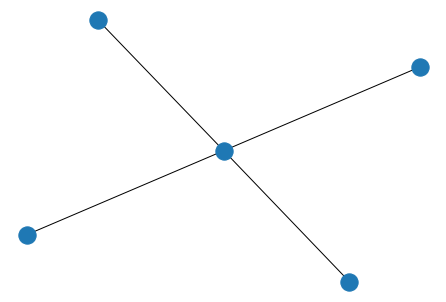

In [940]:
nx.draw(clusters[1]['graph'])

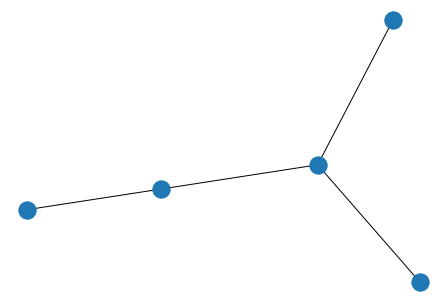

In [941]:
nx.draw(clusters[0]['graph'])

In [44]:
clusters

[{'id': 0,
  'graph': <networkx.classes.graph.Graph at 0x7f8a193a4bd0>,
  'node': [5, 13, 1, 10, 6],
  'p_level': 0.77,
  'CH': 1,
  'total_cmp': 19,
  'total_cmu': 14,
  'total_hir': 21.8,
  'total_pri': 42.1,
  'total_cst': 96.9},
 {'id': 1,
  'graph': <networkx.classes.graph.Graph at 0x7f8a19397cd0>,
  'node': [7, 8, 4, 9, 0],
  'p_level': 1,
  'CH': 7,
  'total_cmp': 30,
  'total_cmu': 14,
  'total_hir': 13.6,
  'total_pri': 34.6,
  'total_cst': 92.2}]

In [35]:
aa= 0
for i in clusters[1]["node"]:
    aa +=G_s.nodes[i]['total_data']
print(aa)

81


In [968]:
for i in list(clusters[0]['graph'].edges):
    print ("{}, {}".format(i, G_s.get_edge_data(i[0],i[1])) )

(5, 13), {'cmu': 2}
(13, 1), {'cmu': 3}
(1, 10), {'cmu': 2}
(1, 6), {'cmu': 4}


In [971]:
clusters


[{'id': 0,
  'graph': <networkx.classes.graph.Graph at 0x7f162c52f650>,
  'node': [5, 13, 1, 10, 6],
  'p_level': 0.77,
  'CH': 1,
  'total_cmp': 19,
  'total_cmu': 14,
  'total_hir': 21.8,
  'total_pri': 42.1,
  'total_cst': 96.9},
 {'id': 1,
  'graph': <networkx.classes.graph.Graph at 0x7f162bfd4310>,
  'node': [7, 8, 4, 9, 0],
  'p_level': 1,
  'CH': 7,
  'total_cmp': 30,
  'total_cmu': 14,
  'total_hir': 13.6,
  'total_pri': 34.6,
  'total_cst': 92.2}]

In [959]:
users_trust

[[1.0, 0.78, 0.97, 0.45, 0.86, 0.97],
 [0.78, 1.0, 0.92, 0.45, 0.77, 0.88],
 [0.97, 0.92, 1.0, 0.57, 0.45, 0.55],
 [0.45, 0.45, 0.57, 1.0, 0.8, 0.49],
 [0.86, 0.77, 0.45, 0.8, 1.0, 0.45],
 [0.97, 0.88, 0.55, 0.49, 0.45, 1.0]]

In [961]:
u_s_table

{0: [5, 6, 10],
 1: [1, 2],
 2: [9],
 3: [8, 11],
 4: [13],
 5: [0, 3, 12],
 'public': [4, 7]}

In [38]:
# data coverage threshold
B = 40
l_num_data = [B]*label
total_num_data = [0]*label

# data balancing threshold
D = 20

#cluster info 
clusters=[]
hired_SIoTs =set()

In [39]:
G_s = nx.Graph()

In [40]:
V_s =[(0, {'cmp': 6,
  'total_data': 21,
  'd_data': [4, 4, 5, 4, 4],
  'p_level': 0,
  'pri_n': -1}),
 (1, {'cmp': 3,
  'total_data': 20,
  'd_data': [4, 4, 4, 4, 4],
  'p_level': 0,
  'pri_n': -1}),
 (2, {'cmp': 4,
  'total_data': 15,
  'd_data': [3, 3, 3, 3, 3],
  'p_level': 0,
  'pri_n': -1}),
 (3, {'cmp': 7,
  'total_data': 21,
  'd_data': [4, 4, 4, 4, 5],
  'p_level': 0,
  'pri_n': -1}),
 (4, {'cmp': 8,
  'total_data': 17,
  'd_data': [3, 3, 3, 4, 4],
  'p_level': 0,
  'pri_n': -1}),
 (5, {'cmp': 5,
  'total_data': 26,
  'd_data': [5, 6, 6, 5, 4],
  'p_level': 0,
  'pri_n': -1}),
 (6, {'cmp': 4,
  'total_data': 18,
  'd_data': [4, 4, 3, 3, 4],
  'p_level': 0,
  'pri_n': -1}),
 (7, {'cmp': 6,
  'total_data': 17,
  'd_data': [3, 4, 3, 4, 3],
  'p_level': 0,
  'pri_n': -1}),
 (8, {'cmp': 5,
  'total_data': 25,
  'd_data': [5, 5, 5, 5, 5],
  'p_level': 0,
  'pri_n': -1}),
 (9, {'cmp': 5,
  'total_data': 22,
  'd_data': [5, 4, 5, 4, 4],
  'p_level': 0,
  'pri_n': -1}),
 (10, {'cmp': 4,
  'total_data': 19,
  'd_data': [4, 4, 4, 4, 3],
  'p_level': 0,
  'pri_n': -1}),
 (11, {'cmp': 5,
  'total_data': 17,
  'd_data': [3, 3, 4, 4, 3],
  'p_level': 0,
  'pri_n': -1}),
 (12, {'cmp': 3,
  'total_data': 19,
  'd_data': [3, 4, 4, 4, 4],
  'p_level': 0,
  'pri_n': -1}),
 (13, {'cmp': 3,
  'total_data': 26,
  'd_data': [5, 4, 6, 5, 6],
  'p_level': 0,
  'pri_n': -1})]


E_s =[(0, 9, {'cmu': 3}),
    (0, 7, {'cmu': 2}),
    (0, 11, {'cmu': 9}),
    (1, 9, {'cmu': 3}),
    (1, 3, {'cmu': 3}),
    (1, 6, {'cmu': 4}),
    (1, 10, {'cmu': 2}),
    (1, 13, {'cmu': 3}),
    (2, 5, {'cmu': 5}),
    (2, 7, {'cmu': 6}),
    (2, 10, {'cmu': 6}),
    (3, 8, {'cmu': 7}),
    (3, 5, {'cmu': 5}),
    (4, 9, {'cmu': 8}),
    (4, 7, {'cmu': 3}),
    (4, 6, {'cmu': 6}),
    (4, 12, {'cmu': 6}),
    (5, 8, {'cmu': 6}),
    (5, 7, {'cmu': 4}),
    (5, 11, {'cmu': 2}),
    (5, 12, {'cmu': 9}),
    (5, 13, {'cmu': 2}),
    (6, 9, {'cmu': 6}),
    (7, 9, {'cmu': 5}),
    (7, 8, {'cmu': 4}),
    (8, 9, {'cmu': 4}),
    (9, 12, {'cmu': 6})
    ]
      
G_s.add_nodes_from(V_s)
G_s.add_edges_from(E_s)


# assign the SIoTs to the users
s_u_table ={0:5,
1:1,
2:1,
3:5,
4: 'public',
5:0,
6:0,
7: 'public',
8:3,
9:2,
10:0,
11:3,
12:5,
13:4
}




# compute trust between each user(i.e., construct the trust table)
users_trust =  [[1.0, 0.78, 0.97, 0.45, 0.86, 0.97],
[0.78, 1.0, 0.92, 0.45, 0.77, 0.88],
 [0.97, 0.92, 1.0, 0.57, 0.45, 0.55],
 [0.45, 0.45, 0.57, 1.0, 0.8, 0.49],
[0.86, 0.77, 0.45, 0.8, 1.0, 0.45],
[0.97, 0.88, 0.55, 0.49, 0.45, 1.0]]